# Decision Trees

<hr style="border:2px solid gray">

# Outline <a id='index'></a>
1. [Classification](#classification)
1. [Overfitting](#overfitting)
1. [Regression](#regression)
1. [Poor Predictors](#poor)
1. [Introduction to Ensemble Learning](#ensemble)
1. [Random Forests](#rf)
1. [Feature Importance](#feature)
1. [Boosting](#boosting)
1. [Appendices](#appendix)
    * [A: Regression DT Code Example](#regression_app)
    * [B: BaggingClassifier Code example](#bagging_app)
    * [C: Adaboost: Mathematics and Code](#adaboost_app)
    * [D: Gradient Boosting: Regression Code Example](#gb_app)

**Keywords:** decision trees, CART Algorithm, overfitting, ensembles, out-of-bag (OOB) score, bagging, pasting, random forests, XGBoost

<hr style="border:2px solid gray">

# Classification [^](#index) <a id='classification'></a>


Like SVMs, decision trees (DTs) are a very popular form of ML, and can be used as a part of even more powerful ML models. They can be used for both classification and regression (although they are most commonly used for classification). 

DTs work by dividing the data along different "hard lines" or "cuts" that best separate the data. They continue to make new cuts this until the classes are fully separated, or until the (user defined) maximum number of cuts has been reached. If possible we want to separate all classes, by making the best possible splits at every opportunity. 

Decision trees are easiest to explain via an example, so let's write a decision tree and have a look. We will look at the IRIS data again:

In [7]:
import numpy as np
import pylab as pl 
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

plt.rcParams['figure.figsize'] = [10, 5] # setting a nice big figure size
iris=load_iris()
display(iris.feature_names)
display(iris.keys())

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris['data'],iris['target'], test_size=0.2,random_state=20) 

Now we have loaded our data in, we will define a decision tree classifier. 

In [9]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=2, random_state =50) 
# max_depth is important as it is the maximum number of divisions. 
# Random_state just means that you will get the same numbers as I do.
clf.fit(X_train,y_train)


,criterion,'gini'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,50
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


We will now calculate the prediction on the test data, print our % accuracy, and plot a representation of the decision tree.

In [14]:
pred=clf.predict(X_test)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, pred))


0.9


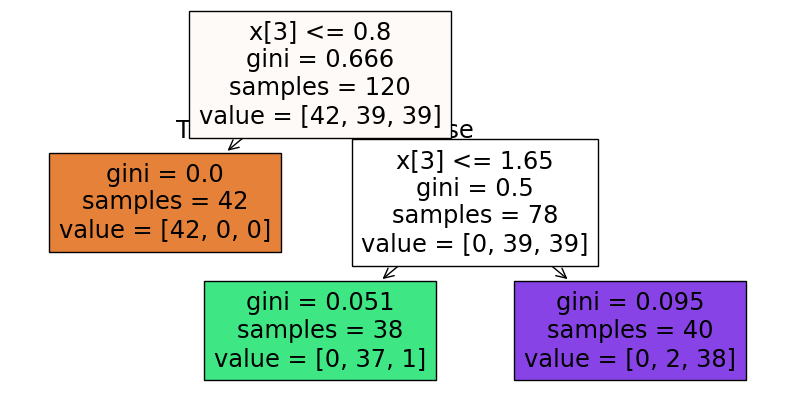

Index:  3 . Threshold:  0.800000011920929
Index:  -2 . Threshold:  -2.0
Index:  3 . Threshold:  1.6500000357627869
Index:  -2 . Threshold:  -2.0
Index:  -2 . Threshold:  -2.0


In [15]:
tree.plot_tree(clf,filled=True)
plt.show()

feature = clf.tree_.feature 
# an array of the indices of each feature being used to split a node
# will be -2 if node is a leaf

threshold = clf.tree_.threshold 
# an array of the threshold value. This will be '-2' if a node is a leaf

for i, j in zip(feature, threshold):
    print ("Index: ", i,". Threshold: ", j)


The diagram above shows the structure of the decision tree. Each box represents a point in the tree where a decision is made, based on some criteria on given inputs. Each node lists the following characteristics of that note:

* The decision criteria at that node; e.g. the first node looks at feature `X[3]` (the petal width) and makes a decision based on whether it is greater or less than 0.8.
<br>

* The value of the **Gini impurity**, which tells you how good a separation you have at that node. We will discuss Gini impurity in more detail later.
<br>

* The total number of samples going into that node.
<br>

* The number of samples in each class, e.g. in the first node we have 42 samples in the first class, 39 in the second, and 39 in the third.

We can talk about three different kinds of node:

* The **root node** is the first node of the decision tree
<br>

* **Internal nodes** (or sometimes just **nodes**) are nodes with arrows to and away from them
<br>

* A **leaf** is a node with only arrows going to it, i.e. at the end of the branch. 

We refer to each arrow following a split as a branch. 

Fitting a decision tree is the process of determining what the nodes should be, in particular what the criteria at each node should be. The algorithm continues dividing the data with nodes until it sees there is no point (i.e. the quality of existing splits is good enough that more splits won't help), or it has reached the maximum depth you allow it to reach. 

For the leaf on the left, the algorithm has identified there is no point dividing any further as we only have one type of iris left in that node. For the two nodes on the right at the bottom, the algorithm has reached its maximum depth of 2 and so stops splitting.


## Choosing the Cut Positions
The location of the cut is chosen to optimise some objective function that quantifies how good our split is. In `sklearn`, this is done using the *Classification and Regression Tree* (CART) algorithm. By default this uses the Gini impurity as the objective function, defined as:

\begin{equation*}
G_i=1-\sum_k p_{i, k}^2
\end{equation*}

where $p_{i,k}$ is the probability of getting a given outcome $k$ for the node $i$, and $G_i$ is the Gini impurity of the $i$-th node. The lower the Gini impurity, the purer the sample. Essentially, if we were to choose a random sample in the set of samples at a given node, and assign it a random label from the set of labels available at that node, the Gini impurity is the probability we would get it wrong. 

So for the tree we got above, you can see that the left-most leaf has a Gini impurity of 0 as it is already pure, whereas the leaf in the middle has an impurity of

$ G= 1- \left(\left(\dfrac{37}{38}\right)^2 +\left(\dfrac{1}{38}\right)^2\right) = 0.051$

Gini impurity is the default, but you can also use entropy, defined as:

\begin{equation*}
H_i=\sum_k p_{i,k}\log_2 (p_{i,k})
\end{equation*}

It is said that Gini tends to produce branches that are pure in one classification, whereas entropy tends to produce a more balanced tree, however I have never made any systematic studies myself. 


<div style="background-color:#000">

## CART algorithm 

The Cart algorithm uses three steps to create a decision tree
1. _Greedy Algorithm_: Before each branch divison, the algorithm will split the training data into two subsets using a particular feature $k$ (e.g. petal width), and a particular threshold $t_{k}$ (e.g. 0.8 cm). k and $t_{k}$ are found by minimising the following cost function:
    
    $J(k,t_{k})= \frac{m_{\text{left}}}{m}G_{\text{left}} + \frac{m_{\text{right}}}{m}G_{\text{right}}$
    
    where $G_\text{left}$ and $G_\text{right}$ are the Gini impurity (or entropy) of the left/right branch respectively, and $m_{\text{left}}$ and $m_\text{right}$ are the number of instances in the left and right branches respectively.
    This process continues recursively, and is called the _greedy_ method because the best split points are chosen each time.
    
    
2. _Stopping Criteria_: The Greedy algorithm needs to know when to stop splitting. This can be achieved in a number of ways, including max_depth and min_samples_leaf (discussed further on)
3. _Tree Pruning_: The **complexity** of a decision tree is defined as the number of splits in the tree. Ideally we would like to minimise complexity (simpler trees are less likely to copy data). The simplest approach to 'prune' the tree is for the algorithm to evaluate the effect of deleting each leaf node.
    
For some more details, see **{homl}**.

How do we make prediction using a decision tree? For a given test sample, we need to follow down the tree and going down the branches where our test input satisfies the various conditions, until we reach a leaf node. At a leaf node, we then need to pick a class to predict; in general, we predict the most common class in the training dataset at that leaf. If two classes are equally common, the first one (in the index order of the training classes) is chosen. 

In the case of our example tree, the left leaf node would always predict the first class, the second leaf node (in the middle) would predict the second class, and the third leaf node (on the right) would predict the third class. 

It is also possible to predict the probability of each class at a leaf node, using the `predict_proba` method. For our first leaf node, it would return a vector [1, 0, 0] (as only the first class is in the training dataset at that leaf). The second leaf node would return [0, 37/38, 1/38] and the third leaf node would return [0, 2/40, 38/40]. 

<div style="background-color: #000">

## Additional DT Example

Below is code to plot the results for the iris dataset, from the sklearn [documentation](https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html#sphx-glr-auto-examples-tree-plot-iris-dtc-py) - it is only included in case you wanted to see how the process works for a (different) tree with multiple dimensions. Most examples we consider will be in two dimensions just as it is easier to visualise. 

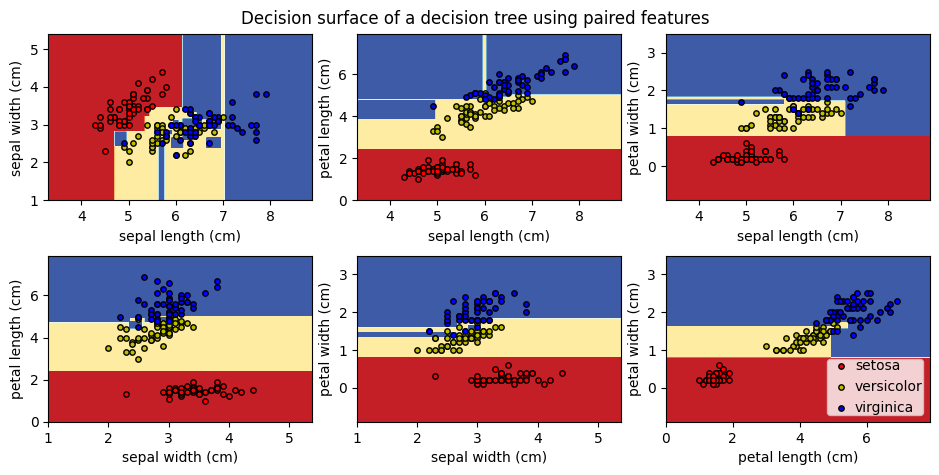

<Figure size 1000x500 with 0 Axes>

In [16]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Parameters
n_classes = 3
plot_colors = "ryb"
plot_step = 0.02

# Load data
iris = load_iris()

for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    X = iris.data[:, pair]
    y = iris.target

    # Train
    clf = DecisionTreeClassifier().fit(X, y)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
    )
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(
            X[idx, 0],
            X[idx, 1],
            c=color,
            label=iris.target_names[i],
            # cmap=plt.cm.RdYlBu,
            edgecolor="black",
            s=15,
        )

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
plt.axis("tight")

plt.figure()
clf = DecisionTreeClassifier().fit(iris.data, iris.target)
#plot_tree(clf, filled=True)
plt.show()

<hr style="border:2px solid gray">

# Overfitting [^](#index) <a id='overfitting'></a>

We will use a more complex example to demonstrate the dangers of overfitting with DTs. Here we use the sklearn `make_moons` function:

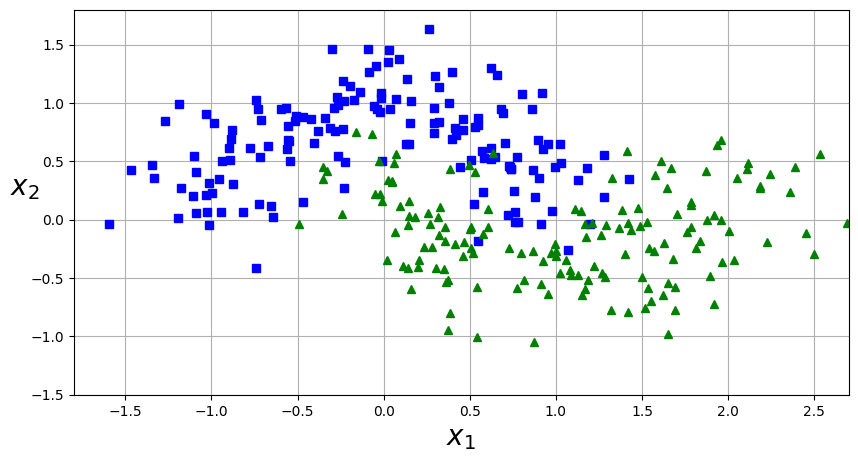

In [17]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=300, noise=0.25, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.8, 2.7, -1.5, 1.8])
plt.show()

We will now split this data into train and test sets, and train a decision tree with a maximum depth of 200:

240


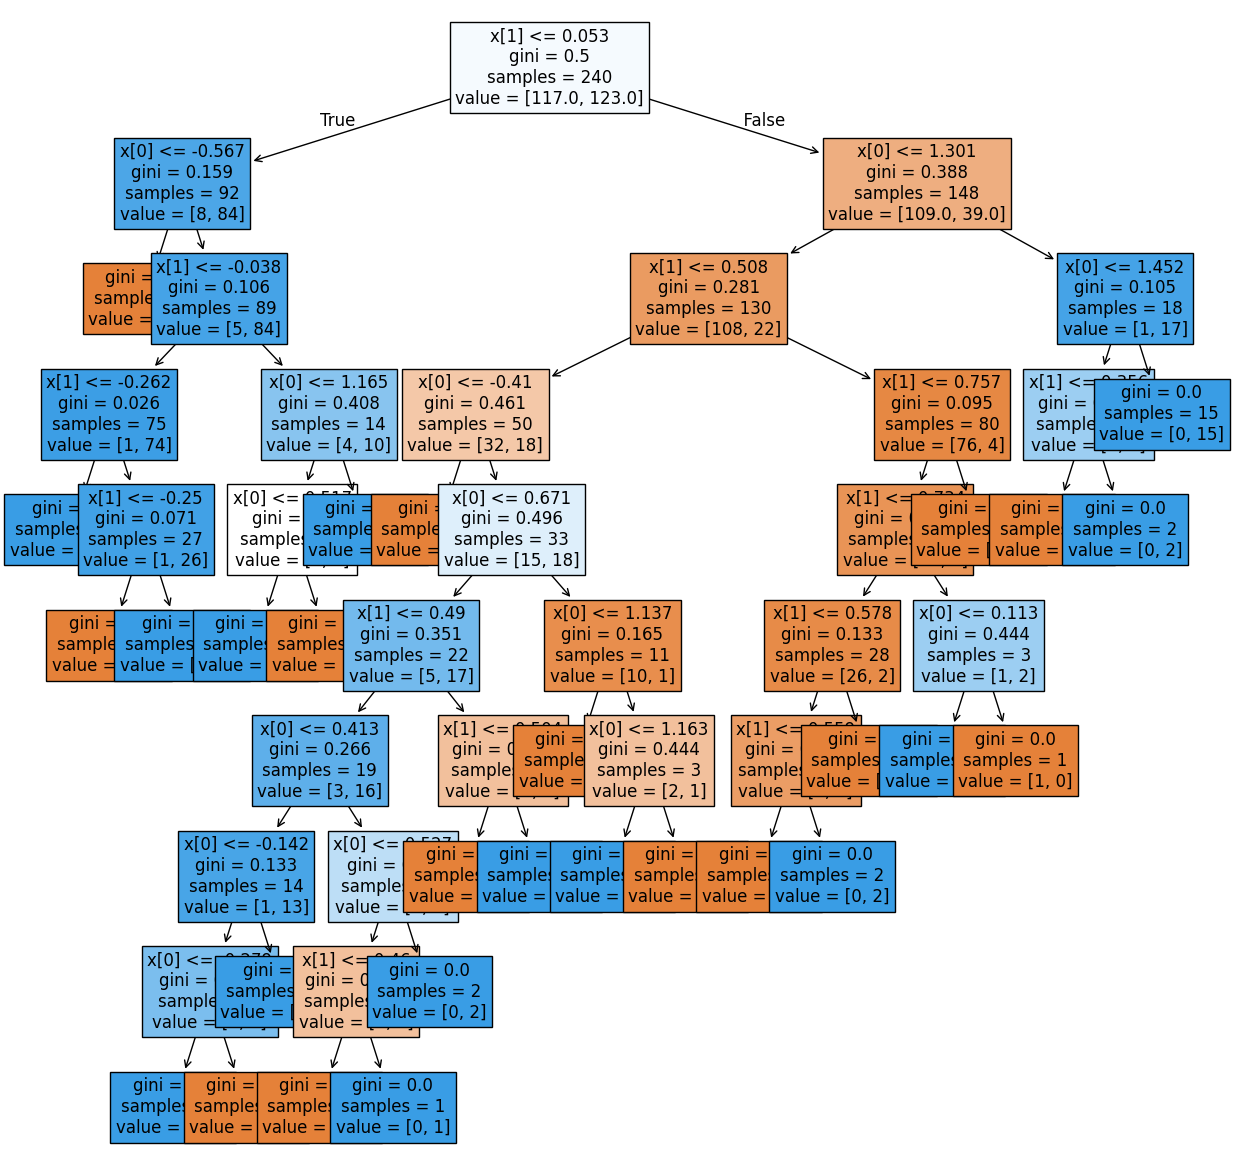

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=20) 
print(len(y_train))
clf = tree.DecisionTreeClassifier(max_depth=200)
plt.rcParams['figure.figsize'] = [15, 15] #nice big plots
clf.fit(X_train,y_train)
tree.plot_tree(clf,filled=True,fontsize=12)
plt.savefig('tree.png')
plt.show()


In [19]:
pred=clf.predict(X_test)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, pred))


0.9166666666666666


Now we have our prediction on the test data, we can write a function to plot the decision boundary in our feature space to show where the decision tree swaps its prediction between classes. We can do this for both training and test data:

In [ ]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    
    custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
    plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^")
        plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)


Plot for training data:

In [ ]:
plt.rcParams['figure.figsize'] = [10, 5] #more reasonable plots
plot_decision_boundary(clf,X_train,y_train, axes=[-1.8, 2.7, -1.5, 1.8])

Plot for test data:

In [ ]:
# now look at the testing data
plot_decision_boundary(clf,X_test,y_test, axes=[-1.8, 2.7, -1.5, 1.8])

Here, we can clearly see our decision boundary is very heavily tuned to our training data, resulting in the complex shape of the boundary. This is overfitting and is a common drawback of decision trees. There are a number of things we can do to help this, through regularisation. These include:

* The `max_depth` parameter controls how many nodes can be in a given branch
<br>

* The `min_samples_leaf` parameter defines the minimum number of samples a leaf must have
<br>

* The `min_samples_split` parameter defines the minimum number of samples a node must have before it can split

<div style="background-color:#C2F5DD">

### Exercise

For this `make_moons` dataset, investigate model performance on training and test data as a function of `max_depth`, ranging from 1 to 200 in steps of 1. Plot both training and test classification accuracy as a function of `max_depth`. At what `max_depth` does the model start overfitting?

In [ ]:
# Your code here

<div style="background-color:#C2F5DD">

### Exercise

Now investigate all three different ways of regularising decision tree performance on this data, and try to understand how well the methods generalise. Consider each method separately by fixing the other two parameters and varying one, then vary all three together to find the best performance you can. Plot the train and test accuracy as a function of your hyperparameter values individually, and see if you can visualize the performance as a function of pairs of variables. 

</div> 


In [ ]:
# Your code here



<hr style="border:2px solid gray">

# Regression [^](#index) <a id='regression'></a>

DTs can also be used for regression, in which case the resulting tree is called a **regression tree**. In this tree, each leaf represents a single numerical value. We can consider a simple, polynomial 2-D case:

In [ ]:
#generate some data
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt

np.random.seed(42)

m = 1000
X = 6 * np.random.rand(m, 1) - 3


y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])

plt.show()

In [ ]:
#Performing our regression fit
reg=tree.DecisionTreeRegressor(max_depth=2)
reg.fit(X,y)

#now draw the results on top of the original
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
xd=np.linspace(-3,3,1000)
yd=reg.predict(xd.reshape(-1,1))
plt.plot(xd,yd,'r-')
plt.show()


In [ ]:
# and the tree itself
tree.plot_tree(reg,filled=True)

<div style="background-color:#C2F5DD">

### Exercise
    
Now try changing max_depth, letting the values fall between 1 and 300. Start off going up in in single units, and then make bigger jumps as the depth increases.
    


In [ ]:
# Your code here



    
We can see that a fairly deep DT is required to approximate the fit, and even then the fit is not continuous. This is a major reason why other regression models are used over regression trees for such continuous data, and DTs are chosen instead for classification.

<div style="background-color:#FFCCCB">

### Mathematics of Regression <a id='regression_main'></a>
    
It is simpler conceptionally to understand how DT work for classification rather than for regression.

At each node, the DT splits the data set according to a specific value of a given feature. The feature and value are chosen to minimise the **sum of the squared residuals** (aka a least squares optimisation problem). This sum is effectively the **loss function** for a regression tree. 

A leaf in a regression DT outputs the average value of all samples at that leaf. The decision tree creates a step-like function, with a step corresponding to each leaf. The constant value of each step is equal to the mean target value of the samples in the leaf.
    
If we were using multiple features, we would split the data along the feature where the loss was minimised.
    
The tree will then continue in the same way as for classification trees.
    
A worked example to make the process clearer is found in [Appendix A](#a-regression-dt-code-example).

<div style="background-color:#C2F5DD">

### Exercise

Now again try using the regularisation methods we have for decision trees to see how good you can make your regression performance. Make sure to split the dataset into train and test datasets, and measure model performance using the mean-squared error on the test dataset. How does it compare to the mean squared error on the training dataset? Again visualize these values as a function of the model hyperparameters.

In [ ]:
# Your code here

<hr style="border:2px solid gray">

# Poor Predictors [^](#index) <a id='poor'></a>


The problem with decision trees is that they are not very good at making predictions (otherwise they would be used everywhere). We can see an example of this by looking at the MNIST digit data again. 

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)
print(mnist.keys())
#Ignore any future warnings, they will not affect the outcome of the code

In [ ]:
X, y = mnist["data"], mnist["target"]

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
print(X_train.shape,X_test.shape)

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=20)
clf.fit(X_train,y_train)

In [ ]:
#print(X_test.shape)
pred=clf.predict(X_test)
#print(pred.shape)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, pred))


In [ ]:
# compare the first 10
predictions=[]
import matplotlib as mpl
for i in range(10):
    plt.subplot(1,10,i+1)
    some_digit = X_test[i] # just to pick an arbitrary figure. Try a different one
    predictions.append(pred[i])
    some_digit_image = some_digit.reshape(28, 28)
    plt.imshow(some_digit_image, cmap=mpl.cm.binary)
    plt.axis("off")
print (predictions)   

<div style="background-color:#C2F5DD">

### Exercise

Use GridSearchCV (as you saw in ML Basics 2) to try to find the hyperparameters that best predict the MNIST data with a decision tree. Carry out the same validation as you did for the kNN algorithm. i.e. best_params_, best_score and test against the testing set. Finally, print out the predicitions for the first 20 numbers and compare with the actual images (you can visualise the images using `plt.imshow`, with the argument `cmap = mpl.cm.binary` to get greyscale images).


In [ ]:
# Your code here

<hr style="border:2px solid gray">

# Introduction to Ensemble Learning [^](#index) <a id='ensemble'></a>

Ensemble learning refers to when many models are used to make a prediction, which is often better than just using one. You can have different types of models all returning an an answer and have a voting scheme between them - sklearn has `VotingClassifier` for this. If a straight vote is taken then voting is said to be **hard** (voting='hard'). However, if the classifiers being called all have a `predict_proba` method then **soft** voting can be used, where the probablility is taken into account. 

The idea of this is that we can train some models to be particularly good at specific tasks, and then when it comes to making predictions we can use the expert for each area rather than trying to train a generic model to do everything.

The area where ensemble learning is used most is with DT.


## Ensemble Learning Example

Here we will train the model on the MNIST dataset, using SVC, SGD and a decision tree.


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier


X, y = mnist["data"], mnist["target"]
X_train, X_test, y_train, y_test = X[:20000], X[20000:], y[:20000], y[20000:]

svc_clf=SVC(max_iter = 30, random_state = 1)
tree_clf = tree.DecisionTreeClassifier(max_depth=20, random_state=1) 
sgd_clf = SGDClassifier(max_iter=20, random_state=1)

voting_clf = VotingClassifier(
    estimators=[('svc', SVC(max_iter = 30, random_state=1)), 
                ('dt', tree.DecisionTreeClassifier(max_depth = 20, random_state=1)),
                ('sgd', SGDClassifier(max_iter = 20, random_state=1))],
    voting='hard')


In [ ]:
from sklearn.metrics import accuracy_score
for clf in (svc_clf, tree_clf, sgd_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

We can see that the `VotingClassifier` outperforms any of the individual classifiers. We can find that taking ensemble predictions may improve generalisations as different individual models learn different features of the data better or worse.

<div style="background-color:#C2F5DD">

### Exercise

Experiment with tuning the hyperparameters of the individual models in the VotingClassifier, and see if you can improve the performance further. Does any of the individual models trained with the same hyperparameters outperform the VotingClassifier? Why do you think this is?

Also, experiment with changing the voting scheme from `'hard'` to `'soft'`, or varying the selection of models used. Record your best performance.

**Note**: as `max_iter` for SVC or SGDClassifier increases, this can start to take a long time to run. Choose a sensible number of combinations to try based on the time you have available.

In [ ]:
# Your code here

## Bagging and pasting <a id='bagging'></a>

Another way of generating lots of estimators is to use the same classifier many times, each time training on a randomly chosen sample from the training set. This is commonly used with decison trees to create a **Random Forest** (discussed in more detail further below).

If these samples are taken with replacement, this is called **bagging** (short for *bootstrap aggregation*). **With replacement** means that when a sample is taken, its features recorded and then it is "thrown back into the bag" - i.e. it can be selected again.

If the samples are taken **without replacement** (i.e. not thrown back), this is called **pasting**. 

You can see more information about bagging classifiers, including a worked example, in [Appendix B](#bagging_app).


<div style="background-color: #FFF8C6">

#### Validation vs Out of Bag (OOB) Score
    
Consider a single classifier in the ensemble:
- It is trained on a small sample of the training data
- The unused training data (specific to each classifier) is called the **Out of Bag** sample. 
- After training, the OOB data is then given as unseen data to the classifier. 
    
The OOB score is the the fraction of correctly classified data from the OOB samples over all classifiers.
    
In contrast, the validation score is calculated from from the test data, which was separated from the training data. All the classifiers in the ensemble will receive the sama data to evaluate.

<!-- _References_: [Towards Data Science](https://towardsdatascience.com/what-is-out-of-bag-oob-score-in-random-forest-a7fa23d710) -->
    


<hr style="border:2px solid gray">

# Random Forests [^](#index) <a id='rf'></a>

Random forests are ensembles of DTs, usually with bagging (possibly with pasting) and where the `max_sample` is around the size of the training sample. Clearly you can build these using the `BaggingClassifier`, however `sklearn` has them built in as `RandomForestClassifier`. See the code below, once again using `make_moons` for our data:

In [ ]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier

X, y = make_moons(n_samples=300, noise=0.25, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=20) 

rfclf=RandomForestClassifier(n_estimators=500,max_leaf_nodes=20,n_jobs=4,oob_score=True)

rfclf.fit(X_train,y_train)
plot_decision_boundary(rfclf,X_train,y_train, axes=[-1.8, 2.7, -1.5, 1.8])

pred=rfclf.predict(X_test)
print(rfclf.oob_score_)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, pred))

If you compare this to [Appendix B](#bagging_app), you can see that we get something relatively similar to our `BaggingClassifier` with this random forest. You can read more about `RandomForestClassifier` in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). 

<hr style="border:2px solid gray">

# Feature Importance [^](#index) <a id='feature'></a>

It is often useful to look at the importance of different features in your data, i.e. how much a given feature affects what class we assign to a sample. For example, look at the example below for the training MNIST data set.

In [ ]:
X_m, y_m = mnist["data"], mnist["target"]
X_train_m, X_test_m, y_train_m, y_test_m = X_m[:60000], X_m[60000:], y_m[:60000], y_m[60000:]

rfclf=RandomForestClassifier(n_estimators=500,max_leaf_nodes=20,n_jobs=4,oob_score=True)
rfclf.fit(X_train_m,y_train_m)



In [ ]:
pred=rfclf.predict(X_test_m)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test_m, pred))


For this data set, each feature is one of the pixels in an image. We can plot a heatmap showing the importance of each pixel. The feature importance is calculated by default in `RandomForestClassifier` and can be accessed via `RandomForestClassifier.feature_importances_`. 

In general there are many ways we can define feature importance, and there are many algorithms to do this. In a decision tree, this is the reduction in the total Gini impurity (or whatever criterion we used) of the decision tree, as a result of using that feature.

In [ ]:
import matplotlib as mpl
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

In [ ]:
plot_digit(rfclf.feature_importances_)

cbar = plt.colorbar(ticks=[rfclf.feature_importances_.min(), rfclf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

The numerical values can be important too (although they do not mean much for the MNIST data). Let us consider our iris dataset again:

In [ ]:
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(iris['data'],iris['target'], 
                                                            test_size=0.2,random_state=20) 
rfclf=RandomForestClassifier(n_estimators=500,n_jobs=4)
rfclf.fit(X_train_i,y_train_i)
display(rfclf.feature_importances_)

# which you can then plot 
import pandas as pd
imps=pd.Series(rfclf.feature_importances_, index=iris.feature_names)
imps.plot.bar()

# There are a number of different ways to plot these and this is just one example.


<div style="background-color:#C2F5DD">

### Exercise

Try varying hyperparameters of random forests to find the best performance you can on the `make_moons` dataset. See the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for details of the `RandomForestClassifier` hyperparameters.

Find and plot the feature importance for your best performing model. Which features are most important?

In [ ]:
# Your code here

<hr style="border:2px solid gray">

# Boosting [^](#index) <a id='boosting'></a>

Another way of combining DTs is through boosting, which is generally more powerful than using a Random Forest. Here you choose your ensembles in non-random ways, generally combining **weak learners** (typically short DTs, defined as classifiers that produce a prediction slightly better than a random guess) to produce **strong learners**. 

There are lots of different boosting algorithms, however two common algorithms are **Gradient Boosting (GB)** and **Adaptive Boosting (AdaBoost)**. 

<div style="background-color: #FFF8C6">


## Gradient Boosting Algorithm Overview <a id='gb'></a>

*Here, we focus on Gradient Boosting for regression. The same general structure applies for classification problems, but it uses many features from **logistic regression** which is beyond the scope of this course.*
    
In Gradient Boosting (GB), we consider two types of model:
    
- A "weak" model (_f_), typically a DT
- A "strong" model (_F_), made of multiple weak models

Initially, the strong model is set as a constant (the average of all the outputs). We can consider this as being a single 'leaf' of a DT, where the samples at that leaf are the outputs of the weak models. The algorithm then improves the model in stages:
    
1. The weak model is trained to predict the *gradient* of the strong model's loss function - this is called the **pseudo response**. 
    
The most popular loss function for Gradient boost regression is: 
\begin{equation}    
\frac{1}{2}(\text{observed}-\text{predicted})^2
\end{equation}     
The derivative of this loss function with respect to the predicted values is simply $-(\text{observed}-\text{predicted})$. This is the 'error'
    
2. The weak model is then added to the strong model with a negative sign to reduce the error of the strong model.
    
3. The process repeats until the stopping criterion is met.
    
We can represent this iteration more mathematically as: 
\begin{equation}    
    F_{i+1} = F_{i} - f_{i}
\end{equation}    
Much like in previously seen ML models, we are in danger of overfitting our model. To fix this we can use **learning rate** or **shrinkage** ($v$), a small value (~0.1) - this is similar to what we saw with an SGD model. Taking many small steps in the 'correct direction' should result in better predictions with a lower variance.
    
\begin{equation}    
    F_{i+1} = F_{i} - vf_{i}
\end{equation}

For a worked code example, see Appendix B: [Gradient Boosting: Regression Code Example](#gb_app).

<div style="background-color: #FFF8C6">
    
## AdaBoost Algorithm Overview <a id='adaboost'></a>
    
AdaBoost is similar in structure to the Random Forest model but with three key differences: 
- In Adaboost, the constituent 'trees' must be **decision stumps** - DTs with depth 1 and just two leaves. In a Random Forest, the depth is not specified.
<br>

- In Adaboost, each constituent stump is weighted based on their classification accuracy. In a Random Forest, each tree gets an equal weight.
<br>

- In Adaboost, unlike in Random Forest, the order that stumps are created is important

The basic process goes as follows:
    
- Initially, all samples are given equal weight (where the weights indicate how important it is for a given sample to be classified correctly)
    
- We then find the decision stump that best classifies the sample data.

- Any incorrectly classified samples are assigned higher weight, so they are more important to classify correctly for the next estimator. The model is also assigned a weight based on its total accuracy.

- The process than repeats by training a new decision tree until all the sample data has been correctly classified, or until the maximm number of repetions have been met.
    
For a worked code example with the detailed mathematics, please read Appendix C: [Adaboost: Mathematics and Code](#adaboost_app).

<div style="background-color: #FFF8C6">
    
## Comparing Adaboost and Gradient Boost (GB)
    
- Adaboost initially creates stumps whereas GB starts with a single leaf. 
- Like Adaboost, GB than builds a size-limited DT based on the errors of the previous trees. However in Adaboost these trees are decision stumps, whereas typically GB has more layers.
- In Adaboost, the decision stumps have different weightings in the overall model; in GB all trees are scaled the same amount by $v$

You can see more details about both AdaBoost and Gradient Boosting in **{homl}**.

<div style="background-color:#C2F5DD">

### Exercise

Now try using `GradientBoostingClassifier` from `sklearn.ensemble` for the `make_moons` dataset. See the [User Guide](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting) for details on how this method works. 

How does the performance compare to your random forest from earlier? Evaluate performance on the test dataset as usual.

In [ ]:
# Your code here

## XGBoost

Although `sklearn` can perform gradient boosting for classification and regression, the best tool available is the very powerful and very fast [XGBoost](https://xgboost.readthedocs.io/en/latest/index.html). XGBoost (e**X**treme **G**radient **B**oost) is a complex algorithm with many constituent parts, and as such we will not include a detailed explanation here. You can find some further information in the XGBoost [documentation](https://xgboost.readthedocs.io/en/stable/tutorials/model.html). A major takeaway is that XGBoost and Gradient Boost both make decision trees to predict the gradient of the loss function (i.e. the error), however XGBoost uses a unique type of DT that aims to divide there errors based on their 'similarity' to one another. 

Below is a very simple example (using the `make_moons` data) just to show that the syntax for the `xgboost` module is the same as with `sklearn`. XGBoost has many different parameters to tune, but for brevity we will only consider a simple use case here.

In [ ]:
from xgboost import XGBClassifier
xgbclf=XGBClassifier(use_label_encoder=False,eval_metric='error') # this is a stop warning that doesn't apply to us anyway - try removing
xgbclf.fit(X_train,y_train)

pred=xgbclf.predict(X_test)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, pred))

plot_decision_boundary(xgbclf,X_train,y_train, axes=[-1.8, 2.7, -1.5, 1.8])
plt.show()

<div style="background-color:#C2F5DD">
    
### Exercise
    
Try varying XGBoost hyperparameters to improve your performance on the `make_moons` data. You can read about the XGBoost hyperparameters in [the documentation](https://xgboost.readthedocs.io/en/stable/parameter.html). 

In particular, consider the hyperparameters `eta`, `gamma`, and `max_depth`, but also try any others you like. Make sure to visualise your performance for each model you try, and potentially try a grid scan of different parameter values.

For further guidance on how to use XGBoost (with its sklearn-like syntax), see the [documentation](https://xgboost.readthedocs.io/en/stable/python/sklearn_estimator.html).

How does the XGBoost performance compare to sklearn's `GradientBoostingClassifier`?

In [ ]:
# Your code here


<div style="background-color:#C2F5DD">

### Exercise

Use random forests and XGBoost boosted decision trees to relook at the MNIST classification problem. Look at different parameters, and if you have time perform a grid scan to see which ones work best. How does the speed of the models compare?

In [ ]:
# Your code here



<hr style="border:2px solid gray">
<hr style="border:2px solid gray">

<div style="background-color:#efdff2">

# Appendix <a id='appendix'></a>

[Return to Outline](#index)

In this section, you will find longer pieces of mathematics and code which are **non-examinable**. Please read at your own discretion.

- A. [Regression DT Code Example](#regression_app)
- B. [Adaboost: Mathematics and Code](#adaboost_app)
- C. [Gradient Boosting: Code Example](#gb_app)

<hr style="border:2px solid gray">

<div style="background-color:#efdff2">

## A. Regression DT Code Example [^](#appendix) <a id='regression_app'></a>
    
[Return to Regression DT section in notes](#regression)

In this section, we will define an algorithm to make a decision tree regressor. This is implemented in `sklearn` as `DecisionTreeRegressor`.

First, we will define a function that splits the data at a given point and calculates the averages on either side. We need to record the positions of these data splits, so that in future iterations we only divide certain sections.

In [ ]:
def calc_regression(y, index, limits_arr):
    '''
    y = The y values of the data
    
    index = The index we will split the data along. 
    NB. The value indexed by index will be in the left grouping
    
    limits_arr = an array that stores our previous limits (including the start and end index)
    '''
    
    repeat=False 
    
    for split_index in limits_arr:
    #This will check if the index is already in the index array
        if (index+1) == split_index:

            repeat=True
            break
    
    limits_arr=np.append(limits_arr, index+1)
    limits_arr=np.sort(limits_arr) #appending the splitting array
    
    length=len(limits_arr)

    loss=0
    avg=[]
    
    if not repeat:

        for i in range(length-1):

            left=limits_arr[i] #the minimum index of the section
            right=limits_arr[i+1] #the maximium index of the section

    
            y_section=y[left:right]

            section_avg=np.average(y_section) #the average of this region

            for val in y_section:
                #adding the residuals
                resid_sq=(val-section_avg)**2
                loss+=resid_sq

            avg.append(section_avg)

        return loss, limits_arr, avg
    
    else: 
        # If we had a repeated index
        return np.inf, [], []
        


<div style="background-color:#efdff2">
    
In this function, we run through all the possible split positions to determine the index with the minimum loss. This is where we will split the data 

In [ ]:
def RSS_low(y, index_arr, plot_los):
    
    min_loss = np.inf
    avg_arr=[]
    index_arr_new=[]

    for i in range(len(y)):
        
        rss, index_check, avg_check = calc_regression(y, i, index_arr)

        if rss < min_loss:
            
            min_loss = rss
            index_arr_new = index_check
            avg_arr = avg_check
            
    return index_arr_new, avg_arr

<div style="background-color:#efdff2">
    
Finally, we will combine these functions so that we can repeat the splitting process multiple times. We will also plot the output.

In [ ]:
def DT_regression(x, y, depth, show_all=False, plot_loss=False):
    
    index_arr=[0,len(x)-1]
    sort=np.argsort(x)
    
    x=x[sort]
    y=y[sort]

    plt.plot(x, y, "b.")
      
    for i in range(depth):
      
        index_arr, avg_arr= RSS_low(y, index_arr, plot_loss) #Calling the RSS function
        
        xd=[]
        yd=[]
        
        prev_x=x[0]

        for limit, avg in zip(index_arr[1:], avg_arr):
            xd.append(prev_x)
            yd.append(avg)
            
            xd.append(x[limit])
            yd.append(avg)
            
            prev_x=x[limit] #Plotting the regression DT fit
            
        if show_all:
        
            plt.plot(xd, yd, lw=3) 
            
    if not show_all:
        plt.plot(xd, yd, lw=3, color='r') 

<div style="background-color:#efdff2">

If you would like, you may experiment with changing the depth of the tree and the number of samples.

In [ ]:
m = 1000
x = 6 * np.random.rand(m) - 3
y = 0.5 * x**2 + x + 2 + np.random.randn(m)


In [ ]:
DT_regression(x, y, 20)  

<hr style="border:2px solid gray">

<div style="background-color:#efdff2">

## B. BaggingClassifier Code example [^](#appendix) <a id='bagging_app'></a>

[Return to bagging section in notes](#bagging)

Here we will go through an example using sklearn's `BaggingClassifier`, with decision trees as our base model.

<div style="background-color:#efdff2">

Let's look again at our `make_moons` data.

In [ ]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=300, noise=0.25, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=20) 

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.8, 2.7, -1.5, 1.8])
plt.show()

<div style="background-color:#efdff2">

If we use a DT without any max_depth set we get:

In [ ]:
print(len(y_train))
clf = tree.DecisionTreeClassifier()
clf.fit(X_train,y_train)
plt.rcParams['figure.figsize'] = [10, 5] #more reasonable plots
plot_decision_boundary(clf,X_train,y_train, axes=[-1.8, 2.7, -1.5, 1.8])

<div style="background-color:#efdff2">

Clearly we have overfitted our model. Instead, we can try generating a large number of estimators using a bagging algorithm. Here, we will generate 500 estimators, each trained on 100 samples from the training data set. We will do this using `sklearn.ensemble.BaggingClassifier`. This takes a number of arguments that you can see in more detail in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html), but some of the key ones are:

* `n_estimators` : the number of different estimates to train to form the ensemble
<br>

* `max_samples` : the number of samples from the training data set to use for each estimator
<br>

* `bootstrap` : whether to draw with replacement or not. `True` means sampling with replacement.
<br>

* `n_jobs` : number of CPU cores to use during training & prediction. Important when we have lots of estimators/data to speed things up.
<br>

* `oob_score` : whether to calculate the out-of-bag score to see how well the model generalises

In [ ]:
# now if we try bagging 
from sklearn.ensemble import BaggingClassifier

bclf=BaggingClassifier(
    tree.DecisionTreeClassifier(),n_estimators=500,max_samples=100, bootstrap=True,n_jobs=4,oob_score=True)

bclf.fit(X_train,y_train)


In [ ]:
plot_decision_boundary(bclf,X_train,y_train, axes=[-1.8, 2.7, -1.5, 1.8])

pred=bclf.predict(X_test)
print('OOB score: ',bclf.oob_score_)
from sklearn.metrics import accuracy_score
print('Validation score: ',accuracy_score(y_test, pred))

<div style="background-color:#efdff2">

We can see our BaggingClassifier performs better than our standard decision tree (and indeed, very similarly to the random forest).

<hr style="border:2px solid gray">

<div style="background-color:#efdff2">

## C. Gradient Boosting: Regression Code Example [^](#appendix) <a id='gb_app'></a>
    
[Return to Gradient Boosting section in notes](#gb)

In this section, we will manually implement an example of gradient boosting. This is available as `GradientBoostClassifier` (or `GradientBoostRegressor`) in `sklearn`. See the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier) for more detail.
    
Once again, we will start by setting up the dataset we want to train from. We will also set our initial prediction as the average of the actual outputs (this is our initial strong function).

In [ ]:
import pandas as pd
from sklearn import tree
import numpy as np
import pylab as pl 

def setup_GB():
    
    global data
    d=[[1.6, 0, True, 88],
       [1.6, 1, False, 76],
       [1.5, 0, False, 56],
       [1.8, 2, True, 73],
       [1.5, 1, True, 77],
       [1.4, 0, False, 57]]
       
    Headers=['Height', 'Fave_Colour', 'Exercise', 'Weight']
    #The numbers of fave_colour correspond to specific colours
    
    df=pd.DataFrame(data=d,columns=Headers)
    length=len(df)

    data = df[['Height', 'Fave_Colour', 'Exercise',]].to_numpy()
    
    df['Prediction']=np.average(df.Weight)
    return (df)

In [ ]:
df=setup_GB()
display(df)

<div style="background-color:#efdff2">

We will now train train our weak model, which is a DT created to predict the errors. We will limit the tree to have four leaves, although when training on larger datasets this value can be increased to 16 or 20.
    
We will then update our previous prediction by subtracting the weak model. However, simply subtracting the predicted errors would lead to **overfitting** and so we also use a learning rate, $v$

In [ ]:
def create_tree_GB(df, show=False, leaf=4):
    
    df['Errors']=df.Prediction - df.Weight
   
    rgr = tree.DecisionTreeRegressor(max_leaf_nodes=leaf)
    rgr.fit(data, df.Errors)
    
    if show:
        tree.plot_tree(clf,filled=True)
        plt.show()
        display(df)
    return (rgr)

def update_prediction(df, lr=0.1):
    df.Prediction=df.Prediction-lr * df.Errors

In [ ]:
rgr=create_tree_GB(df, show=True)
update_prediction(df, lr=0.1)

<div style="background-color:#efdff2">

Our overall model will be the sum of all these regressors. We will define an overall function that trains the model, and another that will use the trained model to make predictions. Experiment with changing the number of trees and the learning rate.

In [ ]:
def GB(n_trees=4, lr=0.1, DT_show=False):
    
    df=setup_GB()
    
    rgr_list=[lr, np.average(df.Weight)]
    #These parameters are useful to the store in the list for the predictions
    
    for i in range (n_trees):
        rgr = create_tree_GB(df, DT_show)      
        rgr_list.append(rgr)
        update_prediction(df, lr)
        
    return rgr_list 

def predict_GB(test_data, rgr_list):
    lr= rgr_list[0]
    predictions=rgr_list[1] * np.ones(len(test_data))
    
    for rgr in rgr_list[2:]:
        error=lr* np.array(rgr.predict(test_data))
        update = predictions - lr * error
        predictions=update
        
    return predictions

In [ ]:
rgr_list = GB()
predictions= predict_GB(data, rgr_list)
print (predictions)

<hr style="border:2px solid gray">

<div style="background-color:#efdff2">

## D. Adaboost: Mathematics and Code [^](#appendix) <a id='adaboost_app'></a>
    
[Return to Adaboost section in notes](#adaboost)
    
In this section, we will demonstrate a manual implementation of Adaboost, through a worked example based on [StatQuest](https://www.youtube.com/watch?v=LsK-xG1cLYA&t=1054s). We want to predict whether a patient has heart disease. Below, we will create the dataframe and also add a weight column for each data sample. Initially the sample weights should be equal, therefore 
    
\begin{equation}    
    w_{i} = 1/N
\end{equation}  
where N is the total number of samples. In this case, N=8.

In [ ]:
#Setting up df
import pandas as pd
def setup():
    global data
    d=[[True,True, 205, True],
        [True,True,180, True],
        [True, False, 210, True],
        [True, True, 167, True],
        [False, True, 156, False],
        [False, True, 125, False],
        [True, False, 168, False],
        [False, True, 172, False]]
    Headers=['Chest_Pain', 'Blocked_Arteries', 'Patient_Weight', 'Heart_Disease']
    df=pd.DataFrame(data=d,columns=Headers)
    length=len(df)

    data = df[['Chest_Pain', 'Blocked_Arteries', 'Patient_Weight']].to_numpy()
    target = df['Heart_Disease'].to_numpy()
    

    df['Statistical_Weight'] = np.ones(length)/length    

    return (df, target)

In [ ]:
df, target=setup()
display(df)

<div style="background-color:#efdff2">

Now we will create our first stump. To find the stump, we will use the same formula as for DTs.

In [ ]:
def create_stump(df, target, show=False):
    
    clf = tree.DecisionTreeClassifier(max_depth=1) 
    clf.fit(data, target, df.Statistical_Weight)
    
    if show:
        tree.plot_tree(clf,filled=True)
        plt.show()

    feature_index = clf.tree_.feature[0]
    feature = df.columns[feature_index]
    threshold = clf.tree_.threshold[0]

    prediction=clf.predict(data)
    check = np.logical_xor(df['Heart_Disease'], prediction)

    #An array telling us if whether the output has been correctly predicted

    df['Matches_Prediction']=np.logical_not(check)
    print('Feature: ', feature, '\t Threshold: ', threshold)

    if show:   
        display(df)
    return (clf)

In [ ]:
create_stump(df, target, True)

<div style="background-color:#efdff2">
    
Our model has done a reasonably good job, only mislabelling one data point at index 3. However, it would be useful to have a numerical value for the error. We therefore define the **total error, $\epsilon$**, as $\sum{w_{w}}$, where ${w_{w}}$ are the weights of the data points which have received the **wrong** classification.

We then define the **amount of say**, **$\alpha$**, as:

\begin{equation}    
    \alpha = \frac{1}{2}\ln\left(\frac{1-\epsilon}{\epsilon}\right)
\end{equation} 

This is essentially how much 'weight' this stump will receive compared to others in the final model. For very accurate models (total error close to 0), the amount of say will be large and positive; for very inaccurate models it will be large and *negative* - this essentially flips the models outputs. If the stump performs to a similar standard to guesswork, $\alpha$ will be close to 0. Note that the amout of say equation will be infeasible for a total error of 0 or 1. To correct this, we often add a small error term to prevent the logarithm from diverging.


In [ ]:
def calc_alpha(df, eps_display=False):
    
    wrong=df[df.Matches_Prediction == False] #Filtering to see where the prediction failed

    epsilon = np.sum(wrong['Statistical_Weight'].to_numpy()) #Summing the weights

    if epsilon==0:
        epsilon= 1e-4 #These error terms have been chosen arbitrarily
    elif epsilon==1:
        epsilon=1-1e-4

    alpha = np.log((1-epsilon)/epsilon)/2

    if eps_display:
        return (alpha, epsilon)
    else:
        return (alpha)


In [ ]:
alpha_1, epsilon_1 = calc_alpha(df, True)
print ('Total error: ',epsilon_1,'. Amount of Say: ', round(alpha_1, 4))

<div style="background-color:#efdff2">
    
We have identified our first stump, and must now update our sample weights. We want to emphasise the importance of correctly identifying data points any previous stumps have failed to identify - in this case we will emphasise the index 3 data. For these incorrect predictions, the new weight is given by:

\begin{equation}    
    w_{i+1} = w_{i}e^{+\alpha}
\end{equation}  

We should also lower the importance of the correctly identified samples, such that the new weights for correctly identified samples are (note the change of sign in front of $\alpha$):

\begin{equation}    
    w_{i+1} = w_{i}e^{-\alpha}
\end{equation}  

The weights must then be normalised. With our new weight values, we can then continue the cycle of creating new decision stumps with the weighted data until all the data has been classified correctly or we have reached the maximum number of repeats.

In [ ]:
def calc_weights(df, alpha):

    df.Statistical_Weight=df.Statistical_Weight* np.exp(-2*(df.Matches_Prediction-0.5))
    #Here we are simply converting our boolean values from 0 and 1 to -1 and 1
    total = sum(df.Statistical_Weight)
    df.Statistical_Weight=df.Statistical_Weight/total

In [ ]:
calc_weights(df, alpha_1)

<div style="background-color:#efdff2">

We can continue generating decision stumps until all the data is correctly classified, or until a stopping criterion is reached (such as maximum number of stumps). 

The model than makes a prediction based on a data point using soft voting. We will use our current example to explain this more clearly:


* The data point to be predicted is classifed by each decision stump
<br>

* All stumps that predict heart disease are grouped together, and their $\alpha$ are summed
<br>

* All stumps that predict no heart disease are grouped, and their $\alpha$ are summed

The model will return whichever classification has a larger total.

In practise, we implement this by identifying "True" as +1 and "False" as -1, and then finding the total sum:

\begin{equation*}
\alpha_\text{pred} = \frac{\sum_i y_i \alpha_i}{\sum_i \alpha_i},
\end{equation*}
where $y_i$ is the prediction of the $i$-th stump and $\alpha_i$ is the amount of say for the $i$-th stump. The sign of the result gives the output prediction, and the magnitude is the confidence in that prediction; it is the net amount of say, as a fraction of the total aount of say of all of the stumps. 
    

In [ ]:
def gen_stumps(n_stumps=3):
    clf_list=[]
    alpha_list=[]
    
    df, target=setup()
    
    for i in range (n_stumps):
        clf = create_stump(df, target)      
        clf_list.append(clf)
        
        a=calc_alpha(df)
        alpha_list.append(a)
        
        calc_weights(df, a)
    
        
    return ([clf_list, alpha_list])   

In [ ]:
output = gen_stumps()
clf_list=output[0]
alpha_list=output[1]

In [ ]:
test_0=[True, True, 220]
test_1=[False, False, 300]
test_2=[False, False, 150]

alpha_total=np.sum(alpha_list)
test=np.array([test_0, test_1, test_2])
weights_arr=np.array([.0,.0,.0])

for clf, alpha in zip(clf_list,alpha_list):
    predict=np.array(clf.predict(test))
    scale=(predict-0.5)*2 #scaling our values, so that False gives -1 and True gives +1
    weight=alpha*scale
    weights_arr=weight+weights_arr

for i in weights_arr:
    print('Heart Disease: ',(i>0), 'with a confidence value of', round(abs(i/alpha_total), 4))

<div style="background-color:#efdff2">


This algorithm is implemented in `sklearn` as `AdaBoostClassifier`. You can read more in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html).